In [2]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median
from bvap_recom import bvap_biased_recom
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import tqdm

In [3]:
graph = Graph.from_file("data/VA_precincts/VA_precincts.shp")

/anaconda3/envs/VRDI/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(887, 892), (892, 914), (887, 893)}
  overlaps
/anaconda3/envs/VRDI/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in column {}!".format(column))


In [4]:
for node in graph.nodes:
    total_pop = graph.nodes[node]['TOTPOP']
    bvap = graph.nodes[node]['BVAP']
    graph.nodes[node]['nBVAP'] = total_pop - bvap
    graph.nodes[node]['population'] = total_pop

In [5]:
# from https://gerrychain.readthedocs.io/en/latest/user/recom.html
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": updaters.cut_edges,
}
elections = [
    Election("BVAP", {"BVAP": "BVAP", "nBVAP": "nBVAP"})
]
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [38]:
import bvap_recom
from importlib import reload
bvap_recom = reload(bvap_recom)

initial_partition = GeographicPartition(graph, assignment="HDIST_11", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
pop_tolerance = 0.15

proposal = partial(bvap_recom.bvap_biased_recom,
                   pop_col="TOTPOP",
                   bvap_col="BVAP",
                   pop_target=ideal_population,
                   epsilon=pop_tolerance,
                   node_repeats=5,
                   target_districts=[86, 87],
                   p_target=0.25
                  )

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, pop_tolerance)

In [39]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [1]:
bvap_86 = []
bvap_87 = []
for run in range(1):
    print('--- Run', run, '---')
    for idx, part in enumerate(chain.with_progress_bar()):
        if idx % 25 == 0: print(idx)
        bvaps = sorted(part['BVAP'].percents('BVAP'))
        bvap_86.append(bvaps[86])
        bvap_87.append(bvaps[87])

--- Run 0 ---


NameError: name 'chain' is not defined

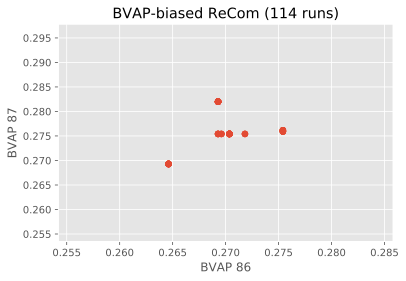

In [41]:
plt.scatter(bvap_86, bvap_87)
plt.xlabel('BVAP 86')
plt.ylabel('BVAP 87')
plt.title(f'BVAP-biased ReCom ({len(bvap_86)} runs)')
#plt.savefig('results/bvap_biased_recom/bvap_86_vs_87.png', dpi=300)
plt.show()